<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Population-receptive-field-mapping" data-toc-modified-id="Population-receptive-field-mapping-1">Population receptive field mapping</a></span><ul class="toc-item"><li><span><a href="#Upsides" data-toc-modified-id="Upsides-1.1">Upsides</a></span></li><li><span><a href="#Downsides" data-toc-modified-id="Downsides-1.2">Downsides</a></span></li><li><span><a href="#Example-applications" data-toc-modified-id="Example-applications-1.3">Example applications</a></span></li><li><span><a href="#Relevance-to-other-analysis-techniques" data-toc-modified-id="Relevance-to-other-analysis-techniques-1.4">Relevance to other analysis techniques</a></span></li></ul></li><li><span><a href="#Relevant-resources/publications" data-toc-modified-id="Relevant-resources/publications-2">Relevant resources/publications</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-3">Simulation</a></span></li></ul></div>

# Population receptive field mapping
Description

## Upsides

lorem

## Downsides
lorem

## Example applications
lorem

## Relevance to other analysis techniques
lorem

# Relevant resources/publications

* Dumoulin, S. O., & Wandell, B. A. (2008). Population receptive field estimates in human visual cortex. Neuroimage, 39(2), 647-660.

# Simulation
First import the data and a few standard Python packages.

In [2]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

# hemodynamic response function
hrf_function = (gamma.pdf(np.arange(20),5) * gamma.pdf(np.arange(20),12))
hrf_function /= np.max(hrf_function)

# pull data from GitHub
import requests, io
for array in ['voxel_by_timeseries','stimulus','receptive_fields','x_ts','y_ts','s_ts']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://github.com/PaulScotti/fmriplayground/raw/main/methods/population_receptive_field_modeling/{}.npy?raw=true'.format(array)).content),allow_pickle=True)
    
# change default plotting
plt.rcParams.update({'font.size': 18, 'figure.figsize': (10,1)})

# overview of the data
num_subjects = 1
num_voxels = voxel_by_timeseries.shape[0] #50 voxels
num_TRs = voxel_by_timeseries.shape[1] #600 TRs

In this simulated dataset we have 1 subject and 50 voxels and our aim will be to characterize a full description of each voxel's receptive field. Unlike phase-encoded mapping / traveling wave, any sort of stimuli may be presented (not just wedges and rings) and we will be characterizing voxel receptive fields by attempting to reconstruct the time series of every voxel based on a few possible parameters (spatial coordinate and size of receptive field). In this simulated experiment the participant was to fixate in the center of the screen while a circular stimulus randomly moves (anywhere up to 10° visual angle horizontally and vertically away from the center of the screen) and changes size (varying between 1° and 10° radius) across the display.

Let's plot the first voxel's time series:

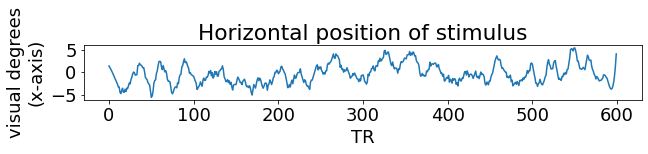

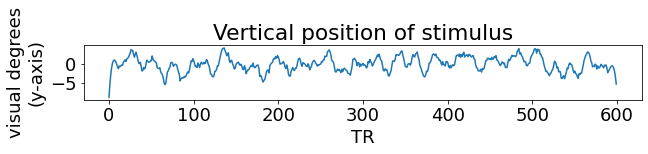

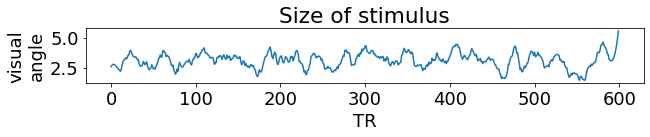

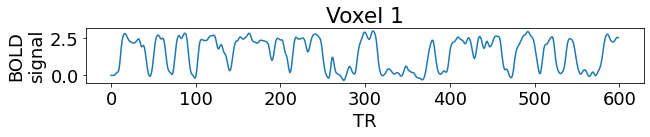

In [3]:
plt.plot(x_ts)
plt.xticks(np.arange(0,num_TRs+1,100))
plt.xlabel("TR")
plt.ylabel("visual degrees\n(x-axis)")
plt.title("Horizontal position of stimulus")
plt.show()

plt.plot(y_ts)
plt.xticks(np.arange(0,num_TRs+1,100))
plt.xlabel("TR")
plt.ylabel("visual degrees\n(y-axis)")
plt.title("Vertical position of stimulus")
plt.show()

plt.plot(s_ts)
plt.xticks(np.arange(0,num_TRs+1,100))
plt.xlabel("TR")
plt.ylabel("visual\nangle")
plt.title("Size of stimulus")
plt.show()

plt.plot(voxel_by_timeseries[0,:])
plt.xticks(np.arange(0,num_TRs+1,100))
plt.xlabel("TR")
plt.ylabel("BOLD\nsignal")
plt.title("Voxel 1")
plt.show()

The aim of population receptive field mapping is to simulate what the BOLD signal should look like for voxels with various possible receptive fields (x:horizontal position, y:vertical position, and s:size) and then see which of these simulated time series looks closest to the actual observed time series for each voxel. The parameters of each best-fitting time series becomes the predicted receptive field properties for each voxel. To demonstrate, let's simulate a time series where the receptive field is situated at a horizontal position of 0° (middle of the screen), a vertical position of 5° (5 visual degrees towards the top of the screen), and a size of 2° (radius of receptive field = 2°). Hence, whenever the moving stimulus appears within 2° near the spatial coordinate of x=0° y=5° then the stimulus is in the receptive field. To simulate a voxel timeseries for this receptive field and stimulus procedure, we can plot the TRs where the stimulus appears in such a receptive field and then convolve this plot with a hemodynamic response function to account for how BOLD responses take some time to initiate and decay.


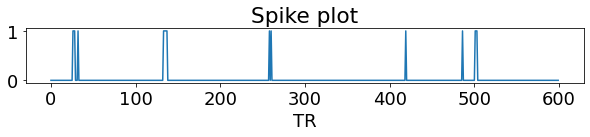

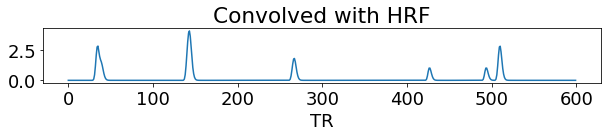

In [4]:
x=0
y=5
s=2

spikes = np.zeros(num_TRs)
spikes[np.intersect1d((np.where((x_ts>x-s) & (x_ts<x+s))[0]),
                           (np.where((y_ts>y-s) & (y_ts<y+s))[0]))] = 1
convolved = signal.convolve(hrf_function,spikes)[:num_TRs]

plt.plot(spikes)
plt.xticks(np.arange(0,num_TRs+1,100))
plt.xlabel("TR")
plt.title("Spike plot")
plt.show()

plt.plot(convolved)
plt.xticks(np.arange(0,num_TRs+1,100))
plt.xlabel("TR")
plt.title("Convolved with HRF")
plt.show()

A simple way to do population receptive field mapping is to first simulate a time series for every possible horizontal position, vertical position, and size


In [5]:
predicted_timecourse = np.full((num_TRs,21,21,10),np.nan)
for xindex,x in enumerate(range(-10,11)):
    for yindex,y in enumerate(range(-10,11)):
        for sindex,s in enumerate(range(1,7)):
            spikes = np.zeros(num_TRs)
            spikes[np.intersect1d((np.where((x_ts>x-s) & (x_ts<x+s))[0]),
                                       (np.where((y_ts>y-s) & (y_ts<y+s))[0]))] = 1
            convolved = signal.convolve(hrf_function,spikes)[:num_TRs]
            predicted_timecourse[:,xindex,yindex,sindex] = convolved

Then, compare all of these time series to each voxel's time series. The time series that looks the closest (e.g., highest correlation coefficient) is then chosen as the best-fitting time series, and the parameters that produced that time series becomes the predicted receptive field properties for the voxel.


In [6]:
predicted_rf = np.full((num_voxels,4),np.nan) # x y s corrcoef
for v in range(num_voxels):
    correlation_to_actual = np.full((21,21,10),np.nan)
    for xindex,x in enumerate(range(-10,11)):
        for yindex,y in enumerate(range(-10,11)):
            for sindex,s in enumerate(range(1,7)):
                correlation_to_actual[xindex,yindex,sindex] = np.corrcoef(predicted_timecourse[:,xindex,yindex,sindex],voxel_by_timeseries[v,:])[0][1]
    predicted_rf[v,:3] = np.array(np.where([correlation_to_actual==np.nanmax(correlation_to_actual)])[1:])[:,0] - [10, 10, -1]
    predicted_rf[v,3] = np.nanmax(correlation_to_actual)

To see how well we did, we can then plot the predicted and actual receptive field properties for horizontal position, vertical position, and size. Note that we can only compare to actual receptive field properties because this is a simulated dataset--you would not normally have access to ground truth receptive field properties for populations of neurons.


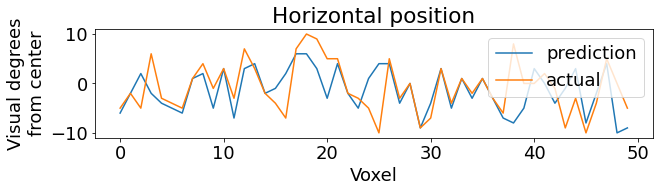

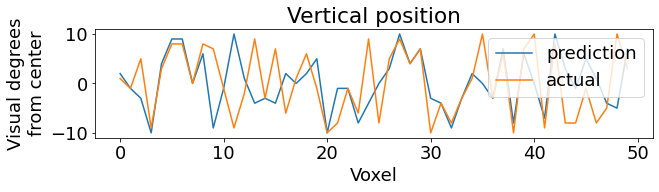

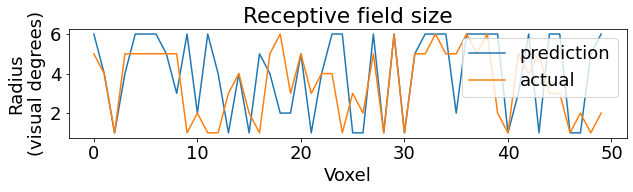

In [7]:
# change default plotting
plt.rcParams.update({'font.size': 18, 'figure.figsize': (10,2)})

plt.plot(predicted_rf[:,0], label='prediction')
plt.plot(receptive_fields[:,0], label='actual')
plt.xlabel("Voxel")
plt.ylabel("Visual degrees\nfrom center")
plt.title("Horizontal position")
plt.legend(loc='upper right')
plt.show()

plt.plot(predicted_rf[:,1], label='prediction')
plt.plot(receptive_fields[:,1], label='actual')
plt.xlabel("Voxel")
plt.ylabel("Visual degrees\nfrom center")
plt.title("Vertical position")
plt.legend(loc='upper right')
plt.show()

plt.plot(predicted_rf[:,2], label='prediction')
plt.plot(receptive_fields[:,2], label='actual')
plt.xlabel("Voxel")
plt.ylabel("Radius\n(visual degrees)")
plt.title("Receptive field size")
plt.legend(loc='upper right')
plt.show()

Note that the above simple approach is useful for general educational purposes, but for practical purposes is inexact and computationally inefficient. For actual implementation, the reader should look into more nuanced approaches for performing population receptive field mapping (see resources section above).


In [4]:
## Code used to simulate the data instead of loading it from GitHub: ##
import numpy as np
from scipy.stats import gamma
from scipy import signal
np.random.seed(1)
num_voxels = 50
num_TRs = 600

hrf_function = (gamma.pdf(np.arange(20),5) * gamma.pdf(np.arange(20),12))
hrf_function /= np.max(hrf_function)

receptive_fields = np.full((num_voxels,3),np.nan)
for v in range(num_voxels):
    x = np.random.choice(21)-10
    y = np.random.choice(21)-10
    s = np.random.choice(6)+1
    receptive_fields[v,:] = [x,y,s]

stimulus = np.full((num_TRs,3),np.nan)
x_ts = np.random.rand(num_TRs)*20 - 10 #-10 to 10 visual degrees
x_ts = signal.savgol_filter(x_ts,21,3)
y_ts = np.random.rand(num_TRs)*20 - 10
y_ts = signal.savgol_filter(y_ts,21,3)
s_ts = np.random.rand(num_TRs)*6
s_ts = signal.savgol_filter(s_ts,21,3)
stimulus = np.array([x_ts,y_ts,s_ts]) 

voxel_by_timeseries=np.full((num_voxels,num_TRs),0.0)
for v in range(num_voxels):
    x,y,s = receptive_fields[v,:]
    voxel_by_timeseries[v,
                        np.intersect1d((np.where((x_ts>x-s) & (x_ts<x+s))[0]),
                                       (np.where((y_ts>y-s) & (y_ts<y+s))[0]))] = 1
    noise = np.random.normal(0,.2,num_TRs)
    voxel_by_timeseries[v,:] += noise
    voxel_by_timeseries[v,:] = (signal.convolve(hrf_function,voxel_by_timeseries[v,:])[:num_TRs])/2

np.save('voxel_by_timeseries.npy',voxel_by_timeseries)
np.save('stimulus.npy',stimulus)
np.save('receptive_fields.npy',receptive_fields)
np.save('x_ts.npy',x_ts)
np.save('y_ts.npy',y_ts)
np.save('s_ts.npy',s_ts)